# Turing Machine and Deep Learning 2023

## Assignment Unupervised ML

This notebook is meant for you to review and reflect on the content of Lecture 3, which was mainly about unsupervised learning problems. As with last week, this notebook should not be too much quantitative work (lines of code) but keep in mind that running this notebook may take a longer time than you may be used to for python programs (*training good models take time!*)

### Handing in your Assignment

Git is an invaluable resource to researchers and developers, and thus for this course, all course material will be (additionally) shared on GitHub. Though there is a tiny bit of a learning curve, this is worth the effort. To hand in your assignment (applicable to all weeks):

1. Create a folder called "Week 2" and copy this notebook and any other files or data that may be needed.
2. Finish the notebook and commit and push regularly. Your final commit before the deadline will be graded.


### Grading

Each one of the (sub-)questions below will be graded either 0 (insufficient), 1 (sufficient) or 2 (good). If $N$ is the number of sub-questions, and $p_i$ is your score for sub-question $i$, your total grade $G$ for this assignment is:
$$G=\frac{1}{2 N}\sum_{i=0}^{N}p_i$$

In [7]:
# load common libraries
import numpy as np                 # maths
import matplotlib.pyplot as plt    # plotting
import pandas as pd                # data manipulation
from tqdm import tqdm              # loading bar
from time import perf_counter      # timer

# Q1 Loading and preprocessing data

In this repository, you should find a file called `tmdb_5000_movies.csv` which is information from a subset of movies on The Movie Database.

### Q.1.1
Use pandas to read in the csv file (refer to [read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) if you're unfamiliar).

In [8]:
from google.colab import files
import pandas as pd
uploaded = files.upload()
df = pd.read_csv('/content/tmdb_5000_movies TMDL 2024.csv')

Saving tmdb_5000_movies TMDL 2024.csv to tmdb_5000_movies TMDL 2024 (1).csv


View information about the dataset including datatypes and null values

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

**Q.1.1.2** What columns have null values above? How would you be able to estimate the missing values?

> Indented block





```
# This is formatted as code
```

homepage -> Since there are so many values missing it might be best to drop the variable /
overview -> since this is a text it might be replaced with "Not available" /
release_date -> this might be researched online or replace with the median date /
runtime -> the missing values can be replaced with the means /
tagline -> since this is a text it might be replaced with "Not available" /



### Q1.2
For this notebook, we're only interested in a few columns, specifically title, overview and genres. Set df to only contain those columns.

In [10]:
df = df[['title', 'overview', 'genres']]
df.info() # print out df info to verify

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     4803 non-null   object
 1   overview  4800 non-null   object
 2   genres    4803 non-null   object
dtypes: object(3)
memory usage: 112.7+ KB


### Q1.3
We see that some movies do not have an overview. Drop them from the table and reset the index (set `drop=True`).

In [11]:
df = df.dropna(subset=['overview']) # drop na values
df.reset_index(drop=True, inplace=True) # reset index

# Q2 One-hot encodings
The following code processes the genres (which you see above are list of dictionaries) and encodes them into one-hot labels.

Remember, since we cannot do maths on text strings, we must change these words to numbers. Here, we create one-hot encodings for the genres. Assume we have three genres $[G_1, G_2, G_3]$. If a movie $M_1$ is tagged with genre $G_1$, the encoding is $[1,0,0]$. If another movie $M_2$ is tagged with $G2$, the encoding becomes $[0,1,0]$. Other encodings are possible as well, but one-hot encoding quite common and useful for many other tasks. In this case, if a movie is tagged with more than one genre, we'll just take a random one and encode that into a one-hot label.

### Q2.1 Processing genres

Finish the following code that processes genres into one-hot encodings.

In [12]:
np.random.seed(0)

def process_genre_string(gs):
    """ Processes genres into a single item from a list"""
    gs = eval(gs)
    gs = [x['name'] for x in gs]
    genre = "Unknown"
    if gs:
        genre = np.random.choice(gs) # choose random entry
    return genre

# TODO: Fill in
def encode_labels(label, unique_labels):
    """ Encodes text labels into a one-hot encoded list
        with possibly more than one one-hot per list.
        :param label: the label you want to one-hot encode
        :unique_labels: the vocabulary
    """
    out = np.zeros(len(unique_labels))
    index = unique_labels.index(label)
    out[index] = 1
    return out

# save genres
processed_genres = [process_genre_string(gs) for gs in df['genres']]

# sort and remove duplicates to get vocabulary
unique_genres = sorted(list(set(processed_genres)))

# add to dataframe as new column
df["proc_genres"] = processed_genres

# one-hot encode genres
encoded_labels = []
for index, row in tqdm(df.iterrows(), total=len(df)):
    encoded_labels.append(encode_labels(row['proc_genres'], unique_genres))

df["one_hot_genres"] = encoded_labels

100%|██████████| 4800/4800 [00:00<00:00, 19466.44it/s]


Verify that one-hot encodings are indeed as expected

In [13]:
df["one_hot_genres"][0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

### Q2.2 Processing Overviews
Next, we process the overviews. First, we remove all punctuation for the sake of simplicity and change each overview to use only lowercase. Then we need to see how long the overviews are in terms of numbers of words. We can do this with a histogram.

**Q2.2.1** Finish the following code

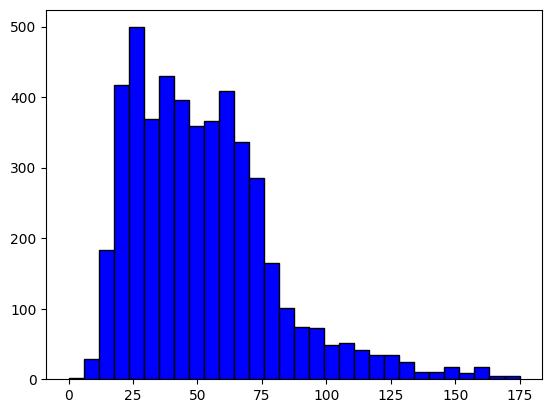

In [14]:
import re
def remove_punctuation(text):
    """ Only retains letters, numbers, underscores and whitespace """
    pattern = r'[^\w\s]'
    return re.sub(pattern, '', text)

processed_overviews = [remove_punctuation(overview).lower() for overview in df['overview']]
df["proc_overview"] = processed_overviews

overview_lens = [len(overview.split()) for overview in processed_overviews]

df["overview_len"] = overview_lens
plt.hist(overview_lens, bins=30, color='blue', edgecolor='black')
plt.show()



```
# This is formatted as code
```

**Q2.2.2** What is the shortest overview? What is the longest? In the next step, we need to decide on a standard length of all overviews -- this means dropping overviews less than some value, and truncating longer ones. What length would you choose to minimize the number of movies dropped and maximize the information (words) stored in the overviews?

I would choose 27.5 as standard length.

### Q2.2.3
Let's choose overviews of length 15 words. What this means is we need to discard movies that have overviews less than 15 (there are other ways of dealing with it, but this should be fine for now) and truncate the higher ones to the first 15 words.

In [15]:
token_len = 15 # number of words
# only select rows where overview len is more than or equal to token_len
df = df[df["overview_len"] >= token_len]

# split each proc_overview into a list of words, select the first token_len words,
# and add the list of words back into df["proc_overview"]
df["proc_overview"] = df["proc_overview"].apply(lambda x: ' '.join(x.split()[:token_len]))

# print to verify
df.head()

<ipython-input-15-5729638812e1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["proc_overview"] = df["proc_overview"].apply(lambda x: ' '.join(x.split()[:token_len]))


,title,overview,genres,proc_genres,one_hot_genres,proc_overview,overview_len
0,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",Action,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",in the 22nd century a paraplegic marine is dis...,28
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",Fantasy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",captain barbossa long believed to be dead has ...,34
2,Spectre,A cryptic message from Bond’s past sends him o...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",Action,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",a cryptic message from bonds past sends him on...,41
3,The Dark Knight Rises,Following the death of District Attorney Harve...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",Thriller,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",following the death of district attorney harve...,65
4,John Carter,"John Carter is a war-weary, former military ca...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",Adventure,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",john carter is a warweary former military capt...,55


### Q2.2.3 Finding the vocabulary length

In order to one-hot encode words, we need to find how many words there are in total, just like in the case of genres. Get all the words, remove duplicates, and sort. Find and print the length of your vocabulary.

In [16]:
# hint: store all words for all movies in a set, change it to a list and sort
words = set()
for overview in df["proc_overview"]:
    words.update(overview.split())
sorted_vocab = sorted(list(words))
vocab_len = len(sorted_vocab)
print(vocab_len)

12493


### Q2.2.4 Encoding the labels

In the case of genres, we one-hot encoded the outputs by taking a single random genre. However, an alternative method is to add up the one-hot encodings to form some kind of histogram. For example, if we have an overview "a brown dog", and our vocab is \[a brown, big, cabbage, dog, goat, cow, turkey\], the one-hot vector would be \[1,1,0,0,1,0,0,0\]. If our overview is "a big brown dog", the one-hot vector would be \[1,1,1,0,1,0,0,0\]. If our overview is "a big big brown dog", the one-hot vector would be \[1,1,2,0,1,0,0,0\]. You can use the `encode_labels` function that you defined earlier.

In [17]:
# this code is just a hint, if you want you can do it as you please
# as long as the output remains the same
# encoded_labels = []
# for index, row in tqdm(df.iterrows(), total=len(df)):
#    sentence_encode = [] # set of encodings for this overview
#    for word in row["proc_overview"]:
#        sentence_encode.append(...) # get encoding for this word
 #   sentence_encode = ... # sum over axis=1
#    encoded_labels.append(...)

#df["one_hot_overview"] = ...
#df['one_hot_overview'] # print to verify


def encode_overview_histogram(overview, vocab_list):
    histogram_vector = np.zeros(len(vocab_list), dtype=int)
    words = overview.split()
    for word in words:
        if word in vocab_list:
            index = vocab_list.index(word)
            histogram_vector[index] += 1
    return histogram_vector

vocab_list = sorted_vocab

encoded_histograms = [encode_overview_histogram(row['proc_overview'], vocab_list) for _, row in tqdm(df.iterrows(), total=df.shape[0])]

df['one_hot_overview'] = encoded_histograms

df['one_hot_overview'].head()

100%|██████████| 4707/4707 [00:18<00:00, 260.06it/s]


0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: one_hot_overview, dtype: object

**Q2.2.5** Each vector is a vector of floating point (64-bit) numbers. Assuming each float takes up exactly 16-bytes, how many bytes does this take to store (theoretically)?

?

# Q3 Principal Component Analysis

**Q3.1** Using the overview encoded into one-hot encodings, perform PCA and plot this into a 2-D image as a scatter plot.

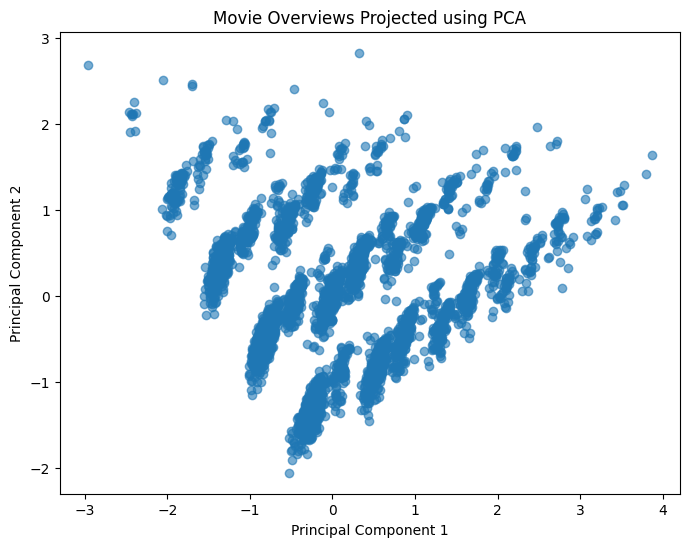

In [18]:
from sklearn.decomposition import PCA

data = np.array(df['one_hot_overview'].tolist())

pca = PCA(n_components=2)

data_pca = pca.fit_transform(data)

plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.6)
plt.title('Movie Overviews Projected using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

**Q3.2** Do you see any interpretable structure in the above plot ("interpretable" $\rightarrow$ the patterns are explainable).

Yes there are clear patterns visible.

**Q3.3** Quantify how much variance information a 2D PCA projection loses for this dataset.

In [19]:
variance_captured = sum(pca.explained_variance_ratio_)
print(1 - variance_captured)

0.887115491324757


**Q3.4** Plot a line graph where the y-axis is cumulative explained variance ratio and the x-axis is the number of PCA components.

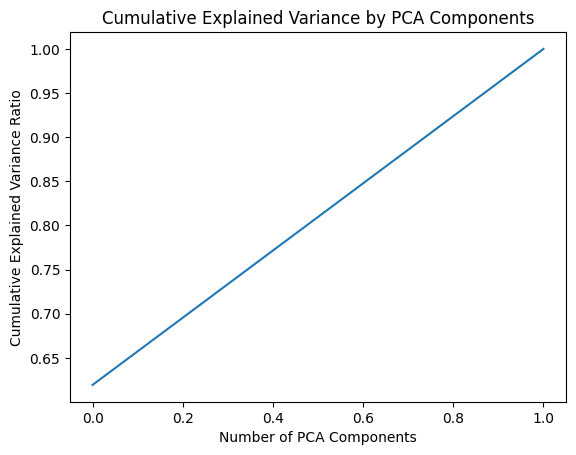

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
# Set up PCA object with the desired number of components
data = np.array(data_pca)
pca = PCA()
# fit transform one_hot_overview encodings
labels_pca = pca.fit_transform(data)
# get explained variance ratio from object, store it in a list
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)


plt.plot(cumulative_explained_variance)
# set up y label, x label, title
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance by PCA Components')
plt.show()

**Q3.5** How many principal components do you need in order to explain 80% of the total variance in the data?

Note: don't just estimate it by eye, write some code to compute it for you.

In [22]:
# your code answer here
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(np.where(cumulative_explained_variance >= 0.8)[0][0] + 1)
NeededComponents = np.where(cumulative_explained_variance >= 0.8)[0][0] + 1

2


2 components needed.

**Q3.6** Using the number of dimensions you found in Q3.5, fit and transform your overview encodings using PCA and add it to a new column called `overview_pca` in the dataframe.

In [23]:
n_dims = NeededComponents
pca = PCA(n_components=n_dims)
labels_pca = pca.fit_transform(data)
df["overview_pca"] = list(labels_pca)

# Q4 K-Means Clustering

**Q4.1** Cluster the movies based on the features that were extracted via PCA in the last step. Set $K=20$. Add the predicted cluster into the dataframe as a new column called `cluster_kmeans`. Print out the elements of cluster number 0 from the dataframe.

In [26]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=42)

y_preds = kmeans.fit_predict(labels_pca)
df["cluster_kmeans"] = y_preds

cluster_0 = df[df["cluster_kmeans"] == 0]
print(cluster_0)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


                                            title  \
7                         Avengers: Age of Ultron   
17    Pirates of the Caribbean: On Stranger Tides   
20                         The Amazing Spider-Man   
52                 Transformers: Dark of the Moon   
77                                     Inside Out   
...                                           ...   
4783                             Breaking Upwards   
4785                               Pink Flamingos   
4786                                        Clean   
4788                                  Tin Can Man   
4790                               On The Downlow   

                                               overview  \
7     When Tony Stark tries to jumpstart a dormant p...   
17    Captain Jack Sparrow crosses paths with a woma...   
20    Peter Parker is an outcast high schooler aband...   
52    Sam Witwicky takes his first tenuous steps int...   
77    Growing up can be a bumpy road, and it's no ex...   
...      

**Q4.2** Does this clustering seem alright to you (based on your movie watching history)? Are there movies that go well together and movies that don't?

I think they fit quite well together. Like only action movies.

**Q4.3** Now, we'll figure out whether using the elbow method is right for this dataset. Plot a loss (using `kmeans.inertia_`) versus cluster size plot. Is there an elbow that you see clearly? What cluster size would you choose?

*Your text answer here*

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

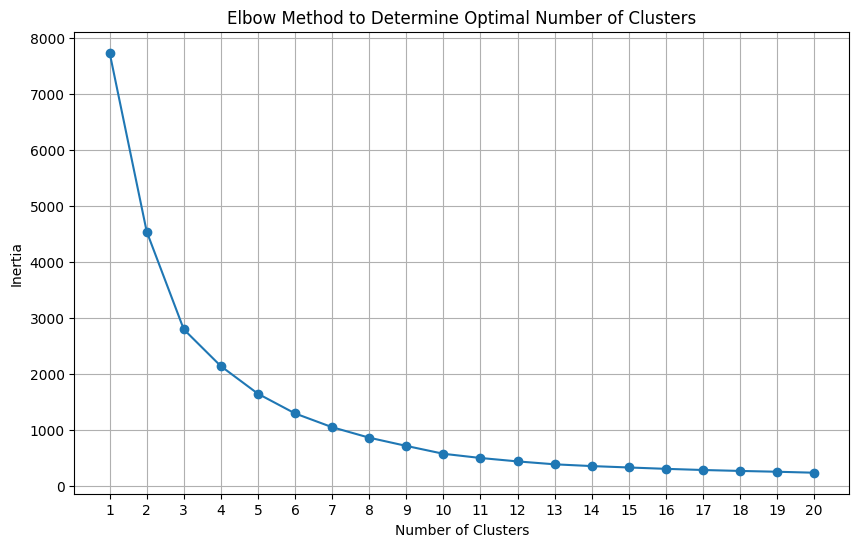

In [27]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

cluster_sizes = range(1, 21)

inertias = []

for k in cluster_sizes:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(labels_pca)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_sizes, inertias, '-o')
plt.title('Elbow Method to Determine Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(cluster_sizes)
plt.grid(True)
plt.show()

# Q5 Gaussian Mixture Models

**Q5.1** As with the K-means above, cluster the movies based on the features that were extracted via PCA in a previous step. Set $K=20$. Add the predicted cluster into the dataframe as a new column called `cluster_gmm`. Print out the elements of a single cluster of your choice from the dataframe.

In [30]:
from sklearn.mixture import GaussianMixture

n_components = 20
gmm = GaussianMixture(n_components=n_components, random_state=42)  # Initialize GMM with 20 components

gmm.fit(labels_pca)
y_preds_gmm = gmm.predict(labels_pca)

df["cluster_gmm"] = y_preds_gmm

cluster_number = 0
cluster_movies = df[df["cluster_gmm"] == cluster_number]
print(cluster_movies)

                                    title  \
27                             Battleship   
50    Prince of Persia: The Sands of Time   
115                               Hancock   
143                                   Pan   
144                 Mr. Peabody & Sherman   
...                                   ...   
4737                             20 Dates   
4741                      Happy Christmas   
4760          Smiling Fish & Goat On Fire   
4765                   The Exploding Girl   
4792                                 Bang   

                                               overview  \
27    When mankind beams a radio signal into space, ...   
50    A rogue prince reluctantly joins forces with a...   
115   Hancock is a down-and-out superhero who's forc...   
143   Living a bleak existence at a London orphanage...   
144   A young boy and his dog, who happens to have a...   
...                                                 ...   
4737  Myles is divorced in L.A. He wants a lov

**Q4.2** Does this clustering seem alright to you (based on your movie watching history)? Are there movies that go well together and movies that don't? How does this compare to K-Means Clustering?



```
# This is formatted as code
```

I dont really know the movies, but I feel like they do not fit very well together, especially compared to K-Means methods.

**Q4.3** Let's check out the size of the clusters. Create a double bar plot (**as you did in the last assignment**) showing the different sizes of the clusters.

*Hint: you may want to consider `df.value_counts()` if you're unfamiliar.*

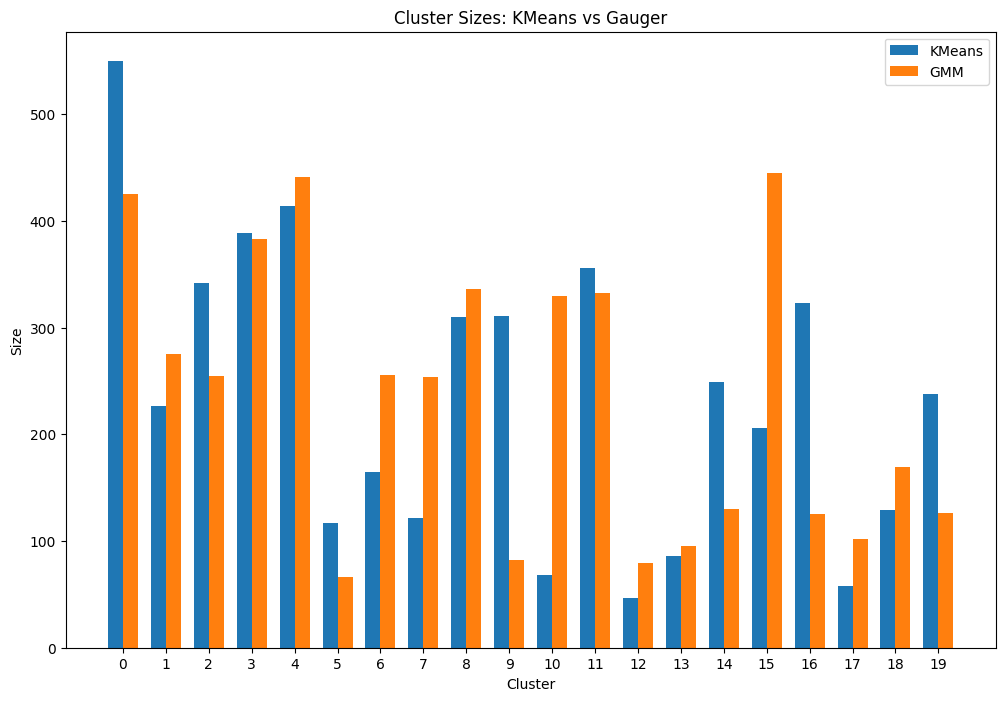

In [33]:
import matplotlib.pyplot as plt

kmeans_cluster_sizes = df['cluster_kmeans'].value_counts().sort_index()
gmm_cluster_sizes = df['cluster_gmm'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 8))

indices = range(len(kmeans_cluster_sizes))
width = 0.35

kmeans_bar = ax.bar(indices, kmeans_cluster_sizes, width, label='KMeans')

gmm_bar = ax.bar([i+width for i in indices], gmm_cluster_sizes, width, label='GMM')

ax.set_xlabel('Cluster')
ax.set_ylabel('Size')
ax.set_title('Cluster Sizes: KMeans vs Gauger')
ax.set_xticks([i+width/2 for i in indices])
ax.set_xticklabels([str(i) for i in indices])

ax.legend()

plt.show()


**Q4.4** Do you see a significant difference in the sizes of the clusters? Which is more uniform? Any thought on why?

Some clusters differ a lot in size.

# Q6: A very simple recommender system

One useful thing that clustering is often used for (though at a much greater complexity) is in **recommender systems**. These are systems with users and items (movies, files, documents, etc.), where new items are shown to the user based on what they've previously interacted with, and possibly also on the behaviour of other users.

**Q6.1** Assume your dentist has just watched the movie Avatar and asks you for a recommendation. Lucky for you, you just finished this assignment. Using the cluster indices of the movie Avatar for both the K-means and GMM methods, print out suggestions for new movies.

In [34]:
prev_watch = "Avatar"

cluster_kmeans = df[df['title'] == prev_watch]['cluster_kmeans'].iloc[0]
cluster_gmm = df[df['title'] == prev_watch]['cluster_gmm'].iloc[0]

print(f"Movies similar to '{prev_watch}' based on K-means clustering (Cluster {cluster_kmeans}):")
similar_movies_kmeans = df[df['cluster_kmeans'] == cluster_kmeans]['title']
print(similar_movies_kmeans.to_string(index=False))

# Print out similar movies based on GMM clustering
print(f"\nMovies similar to '{prev_watch}' based on GMM clustering (Cluster {cluster_gmm}):")
similar_movies_gmm = df[df['cluster_gmm'] == cluster_gmm]['title']
print(similar_movies_gmm.to_string(index=False))

Movies similar to 'Avatar' based on K-means clustering (Cluster 18):
                                         Avatar
                                The Jungle Book
                                Angels & Demons
                                   The Revenant
                                       R.I.P.D.
                                     Prometheus
                               Django Unchained
                                    Cloud Atlas
                              The Fifth Element
                                    Seventh Son
                                     Safe House
                                    Tower Heist
                                 Shutter Island
                                         Robots
                                      The Siege
                         The Tale of Despereaux
                                            Joy
                            Intolerable Cruelty
                                   Leatherheads
                   

**Q6.2** Are any of the two recommender systems any good? Would you use them if your real dentist asks for a movie suggestion?


Yes I think they are decent suggestions.

**Q6.3** How would you try making the recommender systems better?

*Your text answer here*

**Q6.4** Say your dentist likes the movies you suggested and has watched a few more since you met him last. How would you incorporate this fact (recommendation based on multiple movies) into your suggestions?

Find the cluster of all of the watched movies. Then check which one is the most common genres or directors. Use collaborative filtering to find users with similar tastes and see what other movies they've watched.

**Q6.5** An alternative method for recommendations is to use your encoded movie-feature vectors (in this case your overview+PCA vector) in order to find out what movie may be most similar to the current one. In the case of K-Means and GMMs, "similarity" referred to Euclidean distance. However, in this exercise, we will use *cosine similarity*, which is another very common similarity measure, and is related to the angle between two vectors. It is defined as:

$$sim(v_1, v_2)=\frac{v_1\cdot v_2}{||v_1||\cdot||v_2||}$$

Where $v_1$ and $v_2$ are vectors and the operator $||\cdot||$ is the norm of the vector. The function ranges from $[-1,1]$ (where 1 means that the vectors point in the same direction).

Define an appropriate function `cosine_sim`. Add a column called `cos_sim_to_avatar` in the df and print out the head of the df, sorted by the similarity. What movies would you recommend now? Is this better than the clustering methods?

In [35]:
def cosine_sim(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

# get overview_pca encoding of previously watched film
prev_watch_enc = df[df['title'] == 'Avatar']['overview_pca'].iloc[0]

sims = [] # set up place to store similarities
for i, row in df.iterrows():
    movie_vec = row['overview_pca']
    sims.append(cosine_sim(prev_watch_enc, movie_vec))

df["cos_sim_to_avatar"] = sims
df = df.sort_values('cos_sim_to_avatar', ascending=False) # sort df
df # print to verify

,title,overview,genres,proc_genres,one_hot_genres,proc_overview,overview_len,one_hot_overview,overview_pca,cluster_kmeans,cluster_gmm,cos_sim_to_avatar
0,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",Action,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",in the 22nd century a paraplegic marine is dis...,28,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.17130556775965675, 1.254563656707005]",18,12,1.000000
2157,Daybreakers,"In the year 2019, a plague has transformed alm...","[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 27, ""na...",Horror,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",in the year 2019 a plague has transformed almo...,42,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.02898891847503824, 0.20356108502608333]",4,3,0.999983
2837,The Fault in Our Stars,Despite the tumor-shrinking medical miracle th...,"[{""id"": 10749, ""name"": ""Romance""}, {""id"": 18, ...",Romance,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",despite the tumorshrinking medical miracle tha...,47,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.007669926501543178, 0.05373591346341826]",4,3,0.999982
61,Jupiter Ascending,In a universe where human genetic material is ...,"[{""id"": 878, ""name"": ""Science Fiction""}, {""id""...",Action,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",in a universe where human genetic material is ...,30,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.024925830114856384, 0.19286625989594153]",4,3,0.999974
3127,Fifty Dead Men Walking,Based on Martin McGartland's real life story a...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...",Thriller,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",based on martin mcgartlands real life story as...,63,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.011050964138415042, 0.08646861603770435]",4,3,0.999963
...,...,...,...,...,...,...,...,...,...,...,...,...
2630,Never Let Me Go,"As children, Kathy, Ruth, and Tommy spend thei...","[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",Romance,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",as children kathy ruth and tommy spend their c...,47,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.21500905131311565, -1.5642320711393018]",19,4,-1.000000
2635,Funny Games,"When Ann, husband George and son Georgie arriv...","[{""id"": 27, ""name"": ""Horror""}, {""id"": 53, ""nam...",Thriller,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",when ann husband george and son georgie arrive...,51,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.18604503333705802, -1.366787740206702]",19,4,-1.000000
434,The Longest Yard,"Pro quarter-back, Paul Crewe and former colleg...","[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",Drama,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",pro quarterback paul crewe and former college ...,55,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.2026926958751743, -1.481342979609385]",19,4,-1.000000
397,It's Complicated,"Ten years after their divorce, Jane and Jake A...","[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",Romance,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",ten years after their divorce jane and jake ad...,54,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.18654085140024373, -1.3673624679389693]",19,4,-1.000000


*Your text answer here*

# Q7 Unsupervised Learning as a Tool

At the end of this brief forey into natural language processing, we will end with an interesting task: can a machine predict the genre of a movie based purely on the first 10 words of its overview?

First, the following cell shuffles the dataset and splits it into a training and test set. The random seed and random state ensure that the train and test samples are the same for you all the time, and *probably* your classmates too. You can verify this by printing out the dataframes and checking it for yourself.

In [36]:
np.random.seed(0)
n_train = int(0.8*len(df))
df_shuffle = df.sample(frac=1, random_state=42).reset_index(drop=True)
df_train = df_shuffle[:n_train].reset_index(drop=True)
df_test = df_shuffle[n_train:].reset_index(drop=True)
print(len(df_train), len(df_test))

3765 942


## Train, test, evaluate

Using a supervised learning method of your choice, try predicting the genre of a movie from the overview. The way you preprocess your data is up to you, and you can take inspiration from the above exercises (e.g. PCA on the one-hot encodings as input, one-hot label encodings as output). There are a number of hyperparameters you can choose depending on your selected method (number of words in your overview, number of dimensions, number of clusters, hyperparameters of your supervised model...), thus, make sure to perform hyperparameter optimization in some way (grid-search, fine-tuning, etc). Once you are happy with how your model is performing, **print out the train_score (accuracy$\in[0,1]$), test_score (accuracy$\in[0,1]$), mean training time (in seconds), and mean inference time (in seconds) of your model**.

If you are already excited about neural networks, you may also choose to use that as your supervised method. The easiest way to do it is with sklearn's `MLPClassifier` module. The main hyperparameter you would need to tune is the architecture of your model -- how many hidden layers, and how large is each one. For this task, in order to get best performance, you do not necessarily need an MLP (multi-layer perceptron) but feel free to experiment.

*Hint: the `train_and_eval` function from the last assignment should be of great help here*

In [ ]:
# your code here: feel free to add extra cells

Write a paragraph of ~150 words about how you went about selecting and tuning your model, and how you may want to make improvements to your model if you were to continue working on this. Plots are very good but not strictly necessary (i.e. try to add plots if you can).

*Your text answer here*

# BONUS

If you are happy with your score and wish to see how well it is doing with respect to other people (a sort of mini-competition), fill out the following form with the train_score (accuracy$\in[0,1]$), test_score (accuracy$\in[0,1]$), mean training time (in seconds), and mean inference time (in seconds) of your model, as well as what method you use. You can submit as many times before the deadline as you wish. Your final results will be correlated with your submission in order to validate your results (if we cannot validate them, they will be immediately disqualified).

[FORM HERE](https://forms.gle/rXRtXScABH5oDLRWA)